In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import math
import os
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from joblib import Parallel, delayed
from scipy.integrate import nquad, quad, simps
from scipy.stats import entropy, gamma, multivariate_normal, norm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier, build_coleman_forest
from sktree.tree import DecisionTreeClassifier

In [3]:
SIMULATIONS = {
    "1": {},
    "2": {"m_factor": 1},
    "3": {"band_type": "ar", "rho": 0.5},
    "4": {"band_type": "ar", "m_factor": 1, "rho": 0.5},
}

In [6]:
n_estimators = 500
seed = 1234
n_jobs = -1

n_jobs_trees = 1

In [17]:
NON_OOB_MODEL_NAMES = {
    "might-honestfraction05-ogv2": {
        "n_estimators": 500,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs_trees,
        "bootstrap": False,
        "stratify": True,
        # "max_samples": ,
        "permute_per_tree": False,
    },
}

OOB_MODEL_NAMES = {
    "might-honestfraction05-bootstrap-permuteonce": {
        "n_estimators": n_estimators,
        "random_state": seed,
        "honest_fraction": 0.5,
        "n_jobs": n_jobs_trees,
        "bootstrap": True,
        "stratify": True,
        "max_samples": 1.6,
        "permute_per_tree": False,
    },
    # "might-honestfraction05-bootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.5,
    #     "n_jobs": n_jobs_trees,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "max_samples": 1.6,
    #     "permute_per_tree": True,
    # },
    # "might-honestfraction025-bootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.25,
    #     "n_jobs": n_jobs_trees,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "max_samples": 1.6,
    #     "permute_per_tree": True,
    # },
    # "might-honestfraction075-bootstrap": {
    #     "n_estimators": n_estimators,
    #     "random_state": seed,
    #     "honest_fraction": 0.75,
    #     "n_jobs": n_jobs_trees,
    #     "bootstrap": True,
    #     "stratify": True,
    #     "max_samples": 1.6,
    #     "permute_per_tree": True,
    # },
}

In [21]:
SAMP_SIZES = [2**i for i in range(8, 12)]
SAMP_SIZES_plot = [2 * 2**i for i in range(8, 10)]
DIM = 4**6
REPS = range(100, 1000)
P = 4096
# SAVE_PATH = "/Volumes/Extreme Pro/cancer/output/power_exp/might-honestfraction05-bootstrap-maxsamples16-permutepertree"
SAVE_PATH = "/Volumes/Extreme Pro/cancer/output/power_exp/"
print(SAMP_SIZES)
n_repeats = 100

SIM_TYPES = ["trunk", "trunk-overlap"]

[256, 512, 1024, 2048]


In [29]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 14))
results = defaultdict(list)
n_dims = 4096

for model_name in NON_OOB_MODEL_NAMES.keys():
    for sim_name in SIM_TYPES:
        for n_samples in SAMP_SIZES:
            for idx in range(n_repeats):
                file_name = (
                    Path(SAVE_PATH)
                    / model_name
                    / sim_name
                    / f"might_{sim_name}_{n_samples}_{n_dims}_{idx}.npz"
                )

                data = np.load(file_name)
                # print(dict(data).keys())
                pval = data["might_pvalue"]

                results["pvalue"].append(pval)
                results["n_samples"].append(n_samples)
                # results['n_dims'].append(n_dims)
                results["sim_name"].append(sim_name)
                results["model"].append(model_name)
                results["idx"].append(idx)

In [43]:
df = pd.DataFrame(results)

print(df.shape)

(800, 5)


In [44]:
df = df[df['sim_name'] == 'trunk']
df["pvalue"] = df["pvalue"] < 0.05

# empirical_power = (1 + (df["pvalue"] <= 0.05).sum()) / (1 + len(df["pvalue"]))
# print(empirical_power)

df = df.groupby(["n_samples", "model"])["pvalue"].agg(["mean", "std"])
df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})

display(df.head())

,,pvalue,pval_std
n_samples,model,,
256,might-honestfraction05-ogv2,0.0,0.0
512,might-honestfraction05-ogv2,0.0,0.0
1024,might-honestfraction05-ogv2,0.0,0.0
2048,might-honestfraction05-ogv2,0.0,0.0


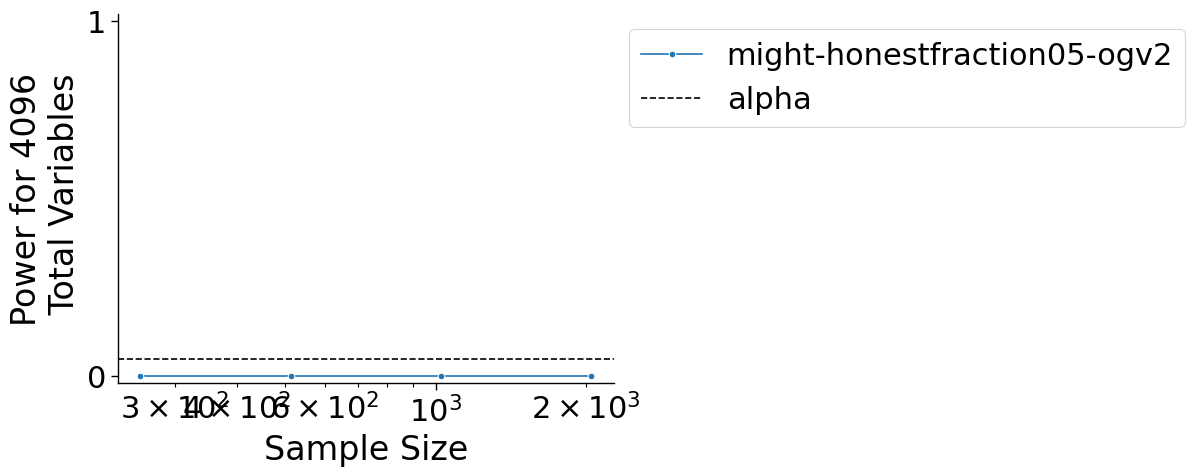

In [45]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots()

# palette = {"MIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    # x="n_features_2",
    x="n_samples",
    y="pvalue",
    marker="o",
    hue="model",
    ax=ax,
    # palette=palette,
    errorbar="ci",
)

ax.set_ylabel("Power for 4096\n Total Variables")
ax.set_xlabel("Sample Size")
ax.set(
    ylim=(-0.02, 1.02),
    # ylim=[0.5, 1],
    yticks=[0, 1],
)
sns.despine(right=True, ax=ax)
ax.axhline([0.05], color="black", ls="--", label="alpha")
ax.set_xscale("log")
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [239]:
print(power_MIGHT)

[0.06965174129353234, 0.06965174129353234, 0.06467661691542288, 0.05970149253731343]
